Intro:
The purpose of this project is to create algorithms to identify metastatic cancer in small image patches taken from digital pathology scans. The data is provided by PCam and this was selected due to its size and approachability. According to the authors, the data set can be trained on a single GPU in a couple of hours making this suitable for the task. 

Data: The data consists many pathology images to be used for binary classification. Each of the images contain an image ID and train labels. The objective will be to predict labels for the test data. The positive lables will indicate that there is tumor issue present in the 32x32px image patch. There are 220,000 training images and 57,000 test images resulting in about 7.76GB of storage. This is quite a large dataset in .tif format that is common in photography and digital imaging.

In [34]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import gc
import random
import sklearn

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

EDA and Data Preprocessing

In [35]:
df_train = pd.read_csv('train_labels.csv')
df_sample = pd.read_csv('sample_submission.csv')

df_train.head()
#df_train.info()
#df_sample.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


From calling .head(), we can see that our data consists of 2 columns. The id column is the name of the corresponding image in .tif format. The second column has 1 or a 0. The 1 indicates if the 32x32px region of patch contains at least a pixel of cancer tissue.

In [36]:
train_folder = "train"
test_folder = "test"

print("Number of training images: {}".format(len(os.listdir(train_folder))))
print("Number of test images: {}".format(len(os.listdir(test_folder))))

Number of training images: 220025
Number of test images: 57458


Now that we've seen how many images are in each folder, I will load some images so we can visualize a sample.

In [37]:
#loading some data
image_train = os.listdir(train_folder)
image_test = os.listdir(test_folder)

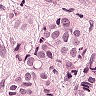

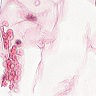

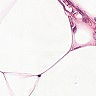

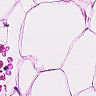

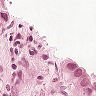

In [38]:
from IPython.display import display, Image  # Import IPython.display for image display
from PIL import Image #for tif

#using Pillow to display a sample of images
num_samples = 5

#generate random indices to loop through
random_indices = random.sample(range(len(image_train)), num_samples)

#looping through random indices to get a sample of images
for index in random_indices:
    img_name = image_train[index]
    image_path = os.path.join(train_folder, img_name)

    # Open the TIFF image using Pillow
    sample_image = Image.open(image_path)

    if sample_image is not None:
        # Display the image in the Jupyter Notebook
        display(sample_image)
    else:
        print(f"failed to load: {image_path}")

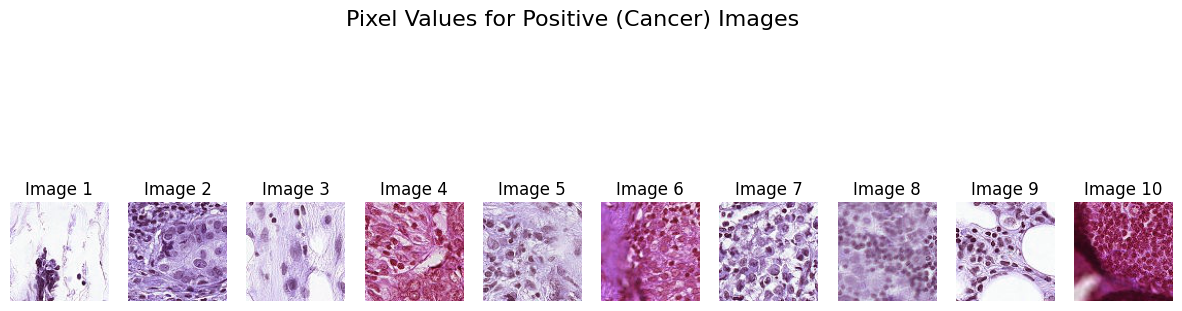

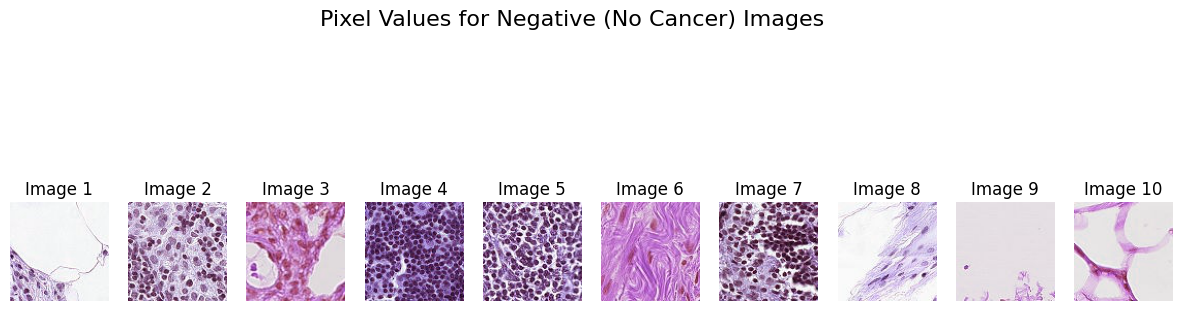

In [39]:
#seperating the postive and negative labels
positive_samples = df_train[df_train['label'] == 1].head(10)
negative_samples = df_train[df_train['label'] == 0].head(10) 

#using opencv to plot
#takes a list of image IDs and a label as arguments
#opens each image, plots its pixel values, and displays it using Matplotlib. 
def plot_pixel_values(images, label):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    fig.suptitle(f"Pixel Values for {label} Images", fontsize=16)

    for i, image_path in enumerate(images):
        image = cv2.imread(os.path.join(train_folder, image_path + ".tif"), cv2.COLOR_BGR2RGB)
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Image {i + 1}")
        axes[i].axis('off')
    plt.show()
    
# Plot pixel values for positive samples
plot_pixel_values(positive_samples['id'], "Positive (Cancer)")

# Plot pixel values for negative samples
plot_pixel_values(negative_samples['id'], "Negative (No Cancer)")    


Now we will visualize the distribution of both cancer and non-cancer images

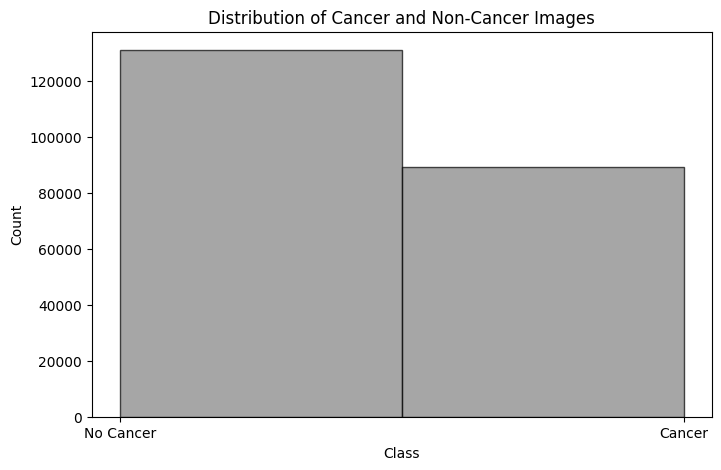

In [40]:
# Function to plot a histogram of the distribution of cancer and non-cancer images
def plot_class_distribution(dataframe):
    plt.figure(figsize=(8, 5))
    plt.hist(dataframe['label'], bins=[0, 0.5, 1], edgecolor = 'black', alpha=0.7, color='gray')
    plt.xticks([0, 1], labels=['No Cancer', 'Cancer'])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Distribution of Cancer and Non-Cancer Images')
    plt.show()

# Plot the distribution
plot_class_distribution(df_train)

From our observation of the distribution between cancer and non-cancer images we can see that the data is not even. This is worth taking into consideration because our model can show some sort of bias if we do not perform further filtering or preporocessing. The correct apporach here seems to be resampling. Below we will perform undersampling so we can reduce the size of the negative or no cancer images in order to balance our data. The benefit in doing this reduces the risk of overfitting. 

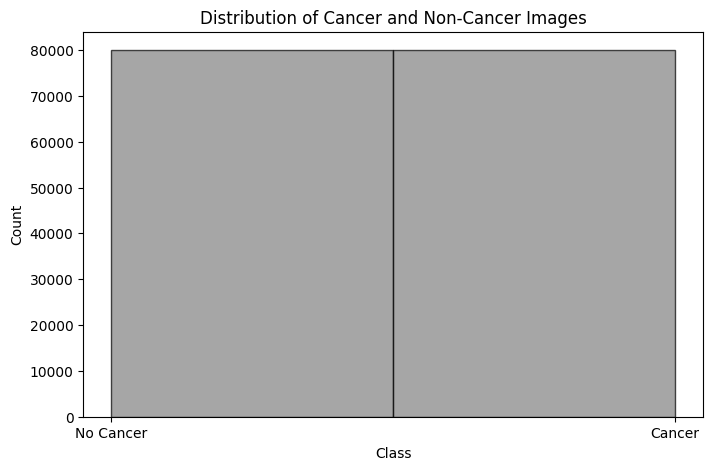

In [41]:
#setting data to 80k equally
sampling_sz = 80000
#getting random samples from images
neg_train = df_train[df_train['label'] == 0].sample(sampling_sz, random_state=42)
pos_train = df_train[df_train['label'] == 1].sample(sampling_sz, random_state=42)

df2_train_sample = shuffle(pd.concat([neg_train, pos_train], axis = 0).reset_index(drop=True))
plot_class_distribution(df2_train_sample)

Below I will implement a simple CNN to see the perfomance of this model. Afterwards I will implement a different model to compare these results to and report on certain metrics. I am implementing functions from Tensforflow and Keras to perform the training and anaylsis.

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

df2_train_sample['label'] = df2_train_sample['label'].astype(str)

#ensuring that the filenames in x_col include extensions if they exist
df2_train_sample['id'] = df2_train_sample['id'].apply(lambda x: x + '.tif')

#verify the correct structure and file names or else I will run into problems
print(f"Sample file path: {os.path.join(train_folder, df2_train_sample['id'].iloc[0])}")

#creating thr model, only 2 Conv2D layers
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

#creating ImageDataGenerator instances
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_generator = train_datagen.flow_from_dataframe(
    df2_train_sample,
    directory=train_folder,
    x_col='id',  
    y_col='label',  # Should be fine as integers for binary
    target_size=(32, 32),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    df2_train_sample,
    directory=train_folder,
    x_col='id',
    y_col='label',
    target_size=(32, 32),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)
#define the model
model = create_model()

#Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Sample file path: train\c8df3247d342e2b9487d913164591895604fa25d.tif
Found 128000 validated image filenames belonging to 2 classes.
Found 32000 validated image filenames belonging to 2 classes.
Epoch 1/5
4000/4000 [==============================] - 1477s 369ms/step - loss: 0.4858 - accuracy: 0.7749 - val_loss: 0.4472 - val_accuracy: 0.7972
Epoch 2/5
4000/4000 [==============================] - 1279s 320ms/step - loss: 0.4344 - accuracy: 0.8059 - val_loss: 0.4125 - val_accuracy: 0.8193
Epoch 3/5
4000/4000 [==============================] - 709s 177ms/step - loss: 0.4149 - accuracy: 0.8148 - val_loss: 0.4154 - val_accuracy: 0.8163
Epoch 4/5
4000/4000 [==============================] - 752s 188ms/step - loss: 0.4023 - accuracy: 0.8215 - val_loss: 0.3738 - val_accuracy: 0.8338
Epoch 5/5
4000/4000 [==============================] - 765s 191ms/step - loss: 0.3932 - accuracy: 0.8259 - val_loss: 0.4110 - val_accuracy: 0.8294


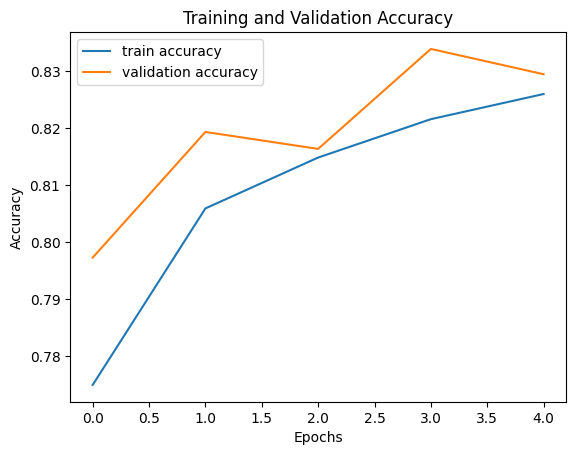

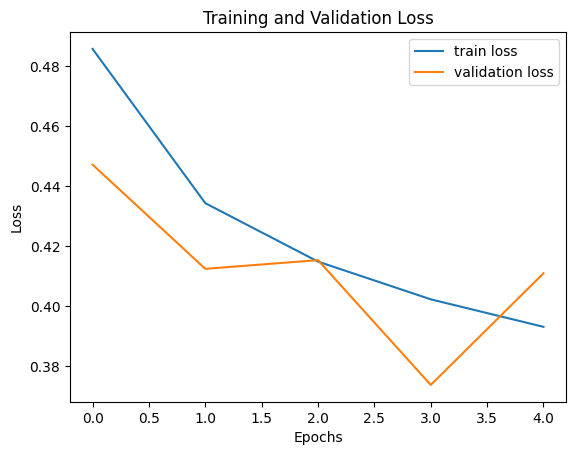

In [45]:
#Plotting the model's training and validation

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


The graphs above show the accuracy/loss on the training and validation set versus the epoch number. We do see what we expect to see from the visual representations so far. I believe that if the model was trained for more epochs we would have already seen convergence within the first 4-8 epochs. 

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#creating ImageDataGenerator instance for test data
test_datagen = ImageDataGenerator(rescale=1./255)

#loading test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'id': os.listdir(test_folder)}),  
    directory=test_folder,
    x_col='id',
    y_col=None,  #no labels in test data
    target_size=(32, 32),
    batch_size=32,
    class_mode=None,  #no labels
    shuffle=False  # Don't shuffle to maintain order for predictions
)


Found 57458 validated image filenames.


In [49]:
# Make predictions
test_predictions = model.predict(test_generator)

# converting to binary labels
binary_predictions = (test_predictions > 0.5).astype(int)


1796/1796 [==============================] - 173s 96ms/step


In [51]:
#creating a DataFrame with predictions
test_results = pd.DataFrame({
    'id': test_generator.filenames,  #filenames from the generator
    'label': binary_predictions.ravel()  #flattening the predictions array
})

print(test_results.head())

                                             id  label
0  00006537328c33e284c973d7b39d340809f7271b.tif      1
1  0000ec92553fda4ce39889f9226ace43cae3364e.tif      1
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif      0
3  000253dfaa0be9d0d100283b22284ab2f6b643f6.tif      1
4  000270442cc15af719583a8172c87cd2bd9c7746.tif      0


Below we will visualize the predictions using the test data and will see whether there is cancer detected in the images with binary classifications.

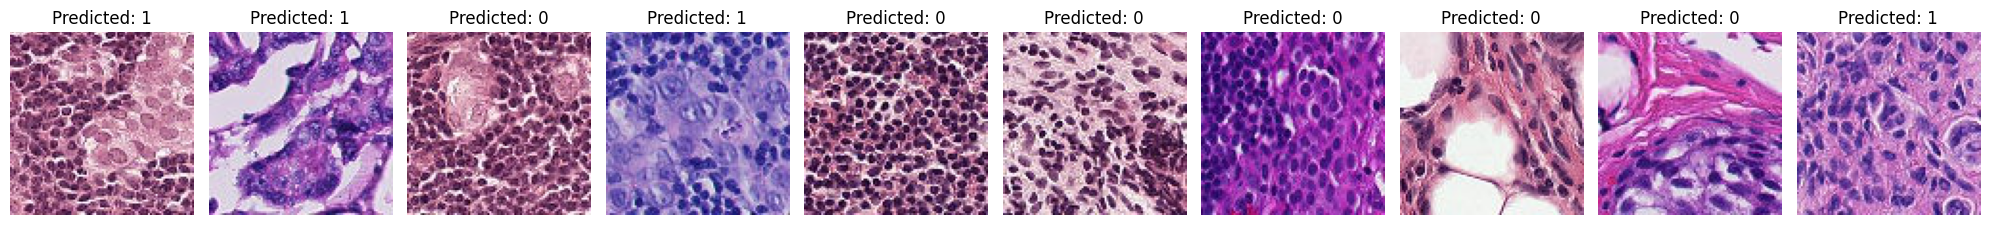

0    34172
1    23286
Name: label, dtype: int64


In [52]:
# Visualizing predictions
import matplotlib.pyplot as plt
import cv2

def visualize_predictions(test_generator, test_results, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    
    for i in range(num_samples):
        # Loading images
        image_path = os.path.join(test_generator.directory, test_results['id'].iloc[i])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # displaying the images
        axes[i].imshow(image)
        axes[i].set_title(f"Predicted: {test_results['label'].iloc[i]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(test_generator, test_results)

# Analyzing prediction distribution
print(test_results['label'].value_counts())

# Save the predictions to a CSV file
#test_results.to_csv('submission.csv', index=False)

Below I will try an alternative architechture to compare results. I will try a Deeper CNN which consists of including more convulational layers compared to my initial model. The purpose of including more layers is to recognize more complex patterns in order to achieve greater accuracy and have a lower loss. 

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

#Deeper CNN model that I will compare for capturing more complexity
def create_deeper_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [54]:
# Definig and training of the model
deeper_model = create_deeper_model()

# Train the model
history_deeper = deeper_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


Epoch 1/5
4000/4000 [==============================] - 1001s 250ms/step - loss: 0.4832 - accuracy: 0.7761 - val_loss: 0.4616 - val_accuracy: 0.7931
Epoch 2/5
4000/4000 [==============================] - 626s 156ms/step - loss: 0.4376 - accuracy: 0.8025 - val_loss: 0.4182 - val_accuracy: 0.8131
Epoch 3/5
4000/4000 [==============================] - 475s 119ms/step - loss: 0.4180 - accuracy: 0.8128 - val_loss: 0.4115 - val_accuracy: 0.8196
Epoch 4/5
4000/4000 [==============================] - 585s 146ms/step - loss: 0.4072 - accuracy: 0.8179 - val_loss: 0.4186 - val_accuracy: 0.8065
Epoch 5/5
4000/4000 [==============================] - 556s 139ms/step - loss: 0.3997 - accuracy: 0.8223 - val_loss: 0.3785 - val_accuracy: 0.8289


Below will be code for visualizing the performances of both models.

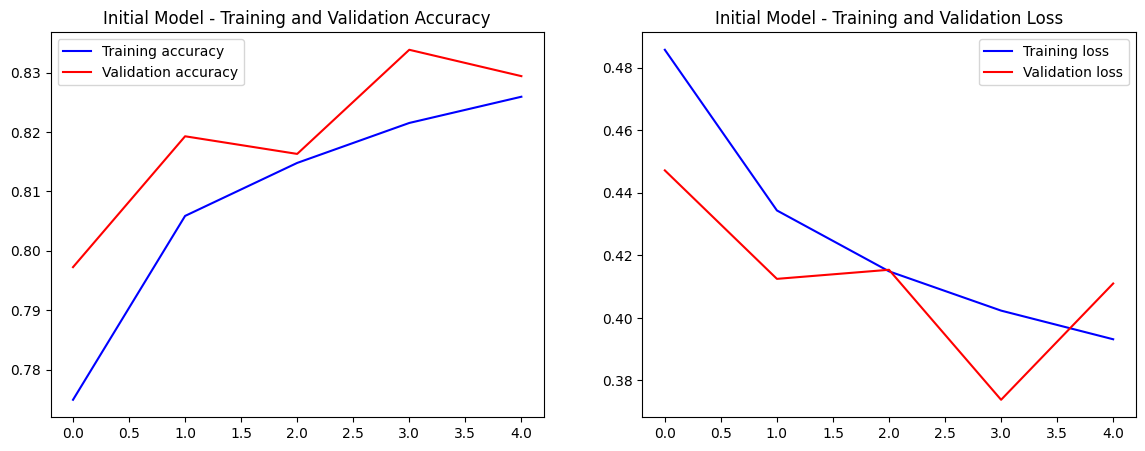

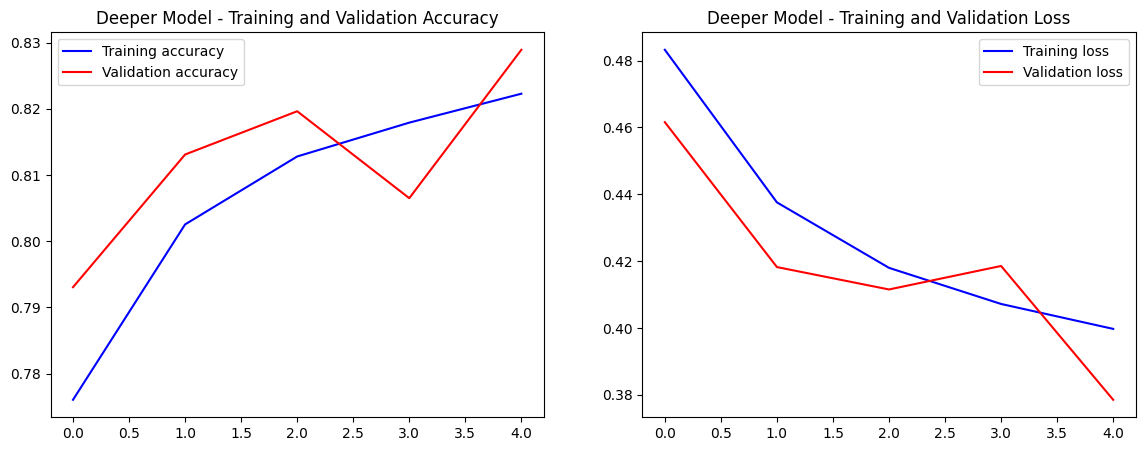

In [61]:
#plotting the performance of both models
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(title + ' - Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title + ' - Training and Validation Loss')
    plt.legend()

    plt.show()

#Plotting the initial model
plot_history(history, 'Initial Model')

#Plotting the deeper model
plot_history(history_deeper, 'Deeper Model')

Conclusion:

The objective of this project was to deploy a model that can accurately predict whether some images contain cancer. In my initial model I used a CNN with a few layers and evaulated the metrics such as the loss and accuracy after doing some training on the validation set of data. Afterwards I compared the performance of my CNN with a Deeper CNN which included more layers and tuning of hyperparameters to come to a conclusion on which model performs best. Due to time constraints I did only run 5 epochs but I believe that was enough to see convergence. I was able to achieve an accuracy of 83.38% with a loss of 0.3738 from my inital model.

The initial model's training and validation accuracy showed a steady increase, with the validation accuracy consistently higher than the training accuracy. The initial model's training and validation loss decreased over time, but the validation loss had a slight increase towards the end indicating potential overfitting. Some things to note are that the Deeper CNN model has a more stable validation loss although similar validation accuracy. This is enough to conclude that the Deeper CNN model is better and can generalize the data better and also had a shorter training time.

In [62]:
#For my kaggle submission
test_results.to_csv('submission.csv', index=False)


print("Submission file 'submission.csv' created successfully.")


Submission file 'submission.csv' created successfully.
